In [1]:
import math
import torch
from torch import nn, optim
import numpy as np
from sklearn.datasets import make_circles
from nflows.flows import Flow as NSF_Flow
from nflows.distributions import StandardNormal
from nflows.transforms import CompositeTransform, RandomPermutation
from nflows.transforms.coupling import PiecewiseRationalQuadraticCouplingTransform
from nflows.nn.nets import ResidualNet
import matplotlib.pyplot as plt


# 1) Toy SSL data generator
def make_circles_ssl(n_total=1000, n_labels_per_class=10, noise=0.05, factor=0.5):
    X, y = make_circles(n_samples=n_total, noise=noise, factor=factor)
    labels = -np.ones(n_total, dtype=int)
    for cls in [0, 1]:
        idxs = np.where(y == cls)[0]
        chosen = np.random.choice(idxs, size=n_labels_per_class, replace=False)
        labels[chosen] = cls
    return X.astype('float32'), labels

# 2) GMM prior & SSL loss
class SSLGaussMixture:
    def __init__(self, means: torch.Tensor):
        self.means = means
        self.K, self.D = means.shape

    def log_prob(self, z):
        mus = self.means.unsqueeze(0)  # [1,K,D]
        zs  = z.unsqueeze(1)           # [B,1,D]
        exp = -0.5 * ((zs - mus)**2).sum(-1)  # [B,K]
        coef = -0.5 * self.D * math.log(2*math.pi)
        logj = coef + exp - math.log(self.K)
        return torch.logsumexp(logj, dim=1)

    def posterior(self, z):
        mus = self.means.unsqueeze(0)
        zs  = z.unsqueeze(1)
        exp = -0.5 * ((zs - mus)**2).sum(-1)
        coef = -0.5 * self.D * math.log(2*math.pi)
        logj = coef + exp - math.log(self.K)
        return torch.softmax(logj, dim=1)

class FlowLoss:
    def __init__(self, prior): self.prior = prior
    def __call__(self, z, ladj, y):
        sup = (y>=0); uns=(y<0); loss=0.0
        if uns.any():
            lp = self.prior.log_prob(z[uns])
            loss += -(lp + ladj[uns]).mean()
        if sup.any():
            post = self.prior.posterior(z[sup])
            ys   = y[sup]
            loss += -torch.log(post[torch.arange(post.size(0)), ys]).mean()
        return loss

# 3) Neural‐Spline Tabular flow
class NeuralSplineTabular(nn.Module):
    def __init__(self, num_layers=5, in_dim=2, hidden=512, bins=8, tail=5.0):
        super().__init__()
        self.tail = tail
        transforms = []
        for i in range(num_layers):
            transforms.append(RandomPermutation(features=in_dim))
            mask = [(i+j)%2==0 for j in range(in_dim)]
            transforms.append(
                PiecewiseRationalQuadraticCouplingTransform(
                    mask=mask,
                    transform_net_create_fn=lambda ic,oc: ResidualNet(
                        in_features=ic, out_features=oc,
                        hidden_features=hidden, num_blocks=2,
                        dropout_probability=0.0, use_batch_norm=False
                    ),
                    num_bins=bins, tail_bound=tail,
                    tails='linear', min_bin_width=1e-3
                )
            )
        self.transform = CompositeTransform(transforms)
        self.flow      = NSF_Flow(transform=self.transform,
                                  distribution=StandardNormal([in_dim]))
        self._ladj     = None

    def forward(self, x):
        z, ladj = self.transform.forward(x)
        self._ladj = ladj       # shape [B]
        return z

    def logdet(self):
        return self._ladj

    

# 4) Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X, labels = make_circles_ssl()
x = torch.from_numpy(X).to(device)
y = torch.from_numpy(labels).to(device)

means = torch.tensor([[3.5,0.],[ -3.5,0.]], dtype=torch.float32).to(device)
prior = SSLGaussMixture(means)

flow    = NeuralSplineTabular().to(device)
loss_fn = FlowLoss(prior)
opt     = optim.Adam(flow.parameters(), lr=1e-5, weight_decay=1e-2)

# split labelled / unlabeled
sup = (y>=0)
x_sup,y_sup = x[sup], y[sup]
x_uns      = x[~sup]
bs = x_sup.size(0)

for t in range(5001):
    idx = torch.randint(0, x_uns.size(0), (bs,), device=device)
    bx  = torch.cat([x_uns[idx], x_sup], dim=0)
    by  = torch.cat([-torch.ones(bs, dtype=torch.long, device=device), y_sup], dim=0)
    z   = flow(bx); ladj = flow.logdet()
    loss= loss_fn(z, ladj, by)
    opt.zero_grad(); loss.backward(); opt.step()
    if t % 500 == 0:
        print(f"Epoch {t:4d} — loss {loss:.4f}")

Epoch    0 — loss 9.6384
Epoch  500 — loss 2.6701
Epoch 1000 — loss 2.2127
Epoch 1500 — loss 1.2912
Epoch 2000 — loss 0.9466
Epoch 2500 — loss 1.3163
Epoch 3000 — loss 1.0020
Epoch 3500 — loss 1.3220


KeyboardInterrupt: 

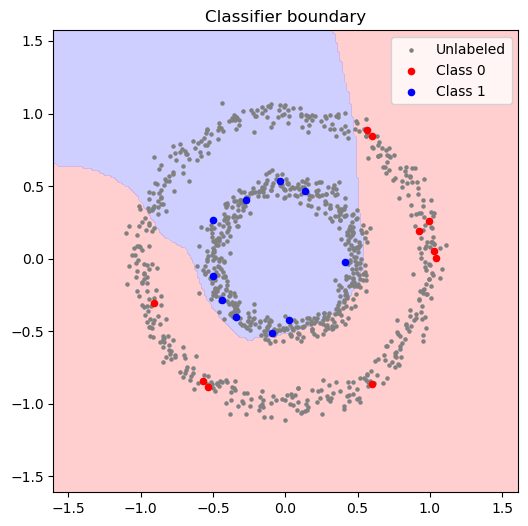

In [3]:
# 5) Classifier decision boundary only (on CPU)
flow_cpu = flow.to('cpu')
prior_cpu = SSLGaussMixture(means.cpu())

# define grids
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xs = np.linspace(x_min, x_max, 200)
ys = np.linspace(y_min, y_max, 200)
xx_x, yy_x = np.meshgrid(xs, ys)

# create test grid points
pts = torch.from_numpy(np.stack([xx_x.ravel(), yy_x.ravel()], 1).astype('float32'))

# predict class probabilities and get decision boundaries
with torch.no_grad():
    z_pts = flow_cpu(pts)
    preds = prior_cpu.posterior(z_pts).argmax(dim=1).numpy().reshape(xx_x.shape)

# plot decision boundary
plt.figure(figsize=(6, 6))
plt.contourf(xx_x, yy_x, preds, levels=[-0.5, 0.5, 1.5], colors=['#FFA0A0', '#A0A0FF'], alpha=0.5)

# plot data points
mask_l = labels >= 0
plt.scatter(X[~mask_l, 0], X[~mask_l, 1], c='gray', s=5, label='Unlabeled')
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], c='red', s=20, label='Class 0')
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c='blue', s=20, label='Class 1')

plt.title('Classifier boundary')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.show()
